In [2]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from typing import TypedDict, Literal 
from pydantic import BaseModel, Field 
from langchain_openai import ChatOpenAI

In [3]:
load_dotenv()

True

In [7]:
model = ChatOpenAI(model = 'gpt-4o-mini')

In [8]:
class sentiment_schema(BaseModel):
    sentiment:Literal['positive','negative']= Field(description='Return the sentiment of the review')

In [9]:
structured_model = model.with_structured_output(sentiment_schema)

In [10]:
class review_state(TypedDict):
    review: str 
    sentiment:Literal['positive','negative']
    diagnosis: dict 
    response:str

In [15]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [16]:
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [11]:
def find_sentiment(state: review_state):
    review = state['review']

    prompt = f'Give the sentiment of the following review - {review}'

    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment':sentiment}

In [12]:
def check_condition(state: review_state):
    sentiment = state['sentiment']

    if sentiment == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

In [14]:
def positive_response(state: review_state):
    
    prompt = f"""Write a warm thank-you message in response to this review:
        \n\n\"{state['review']}\"\n
        Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

In [17]:
def run_diagnosis(state: review_state):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

In [18]:
def negative_response(state: review_state):
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [21]:
graph = StateGraph(review_state)

graph.add_node('find_sentiment',find_sentiment)



graph.add_node('positive_response',positive_response)

graph.add_node('negative_response',negative_response)
graph.add_node('run_diagnosis',run_diagnosis)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_condition)
graph.add_edge('find_sentiment','run_diagnosis')
graph.add_edge('find_sentiment','positive_response')
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('positive_response',END)
graph.add_edge('negative_response',END)

workflow = graph.compile()

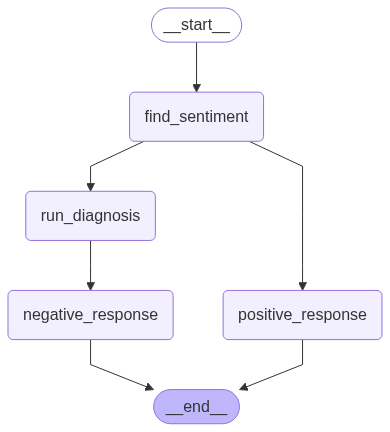

In [22]:
workflow

In [23]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: We're Here to Help with Your Bug Issue\n\nHi [User's Name],\n\nI hope this message finds you well. I understand that you’re experiencing a bug that’s causing frustration, and I want to sincerely apologize for any inconvenience this has caused you. I appreciate you bringing this to our attention, and I assure you that we're here to help resolve the issue as quickly as possible.\n\nTo assist you better, could you please provide a few more details? Specifically, if you could share the steps you took when the bug occurred, any error messages you received, and the device or platform you are using, that would be immensely help